## Loading data products

- Load remote data for desired moorings
- Write data locally
- Extract a single timeseries at the deepest well-sampled depth for each mooring 

Using the [loading_data_products.ipynb](loading_data_products.ipynb) notebook as a starting point.

In [1]:
import sys
from glob import glob
from pathlib import Path

sys.path.insert(0, "../sa_upwelling")   # Allows using the files in the Python package
import utils

from matplotlib import pyplot as plt

SA coastal moorings that are active: 
* SAM8SG
* SAM5CB
* NRSKAI (National Reference Station Kangaroo Island, NRS division)

SA coastal moorings that are not active but have data available:
* SAM2CP
* SAM6IS
* SAM3MS
* SAM7DS

**Notes:**
* Look at TS for details: https://imos.org.au/fileadmin/user_upload/shared/ANMN/SA_Moorings/06c._Southern_Australia_Moorings_-_TS.pdf
* Aggregate has data only from termistor
* Avoid CTD-derived data (look out for anomalies)


In [2]:
# See default moorings in the 'utils' module
utils.DEFAULT_MOORINGS

[('NRS', 'NRSKAI'),
 ('SA', 'SAM8SG'),
 ('SA', 'SAM5CB'),
 ('SA', 'SAM2CP'),
 ('SA', 'SAM6IS'),
 ('SA', 'SAM3MS'),
 ('SA', 'SAM7DS')]

### Hourly time-series

If you are running this for the first time, it might take a while as data is downloaded.

In [3]:
hourly_files, hourly_datasets = utils.load_data_products()

Loading local hourly-timeseries data for mooring 'NRSKAI'.
Loading local hourly-timeseries data for mooring 'SAM8SG'.
Loading local hourly-timeseries data for mooring 'SAM5CB'.
Loading local hourly-timeseries data for mooring 'SAM2CP'.
Loading local hourly-timeseries data for mooring 'SAM6IS'.
Loading local hourly-timeseries data for mooring 'SAM3MS'.
Loading local hourly-timeseries data for mooring 'SAM7DS'.


**Datasets can be accessed by using the `hourly_datasets` dictionary.**

In [4]:
hourly_datasets["NRSKAI"]

<xarray.Dataset>
Dimensions:           (OBSERVATION: 1547369, INSTRUMENT: 544)
Coordinates:
    TIME              (OBSERVATION) datetime64[ns] 2008-02-12T08:00:00 ... 20...
    LONGITUDE         (INSTRUMENT) float64 136.4 136.4 136.4 ... 136.4 136.4
    LATITUDE          (INSTRUMENT) float64 -35.84 -35.84 ... -35.84 -35.84
    NOMINAL_DEPTH     (INSTRUMENT) float32 105.3 109.2 106.4 ... 100.8 33.55
Dimensions without coordinates: OBSERVATION, INSTRUMENT
Data variables: (12/48)
    instrument_index  (OBSERVATION) int32 0 0 0 0 0 0 ... 543 543 543 543 543
    instrument_id     (INSTRUMENT) |S256 b'NRSKAI-0802; RDI ADCP-WORKHORSE-SE...
    source_file       (INSTRUMENT) |S256 b'IMOS/ANMN/NRS/NRSKAI/Velocity/IMOS...
    DEPTH             (OBSERVATION) float32 104.7 104.6 104.6 ... 33.44 33.89
    DEPTH_count       (OBSERVATION) float32 4.0 6.0 6.0 6.0 ... 1.0 1.0 1.0 1.0
    DEPTH_min         (OBSERVATION) float32 104.6 104.6 104.6 ... 33.44 33.89
    ...                ...
    PSAL_std          (OBSERVATION) float32 nan nan nan nan ... nan nan nan nan
    TEMP              (OBSERVATION) float32 12.77 11.17 11.03 ... 17.96 17.95
    TEMP_count        (OBSERVATION) float32 6.0 6.0 6.0 6.0 ... 1.0 1.0 1.0 1.0
    TEMP_max          (OBSERVATION) float32 16.42 11.27 11.06 ... 17.96 17.95
    TEMP_min          (OBSERVATION) float32 11.31 11.09 11.01 ... 17.96 17.95
    TEMP_std          (OBSERVATION) float32 2.036 0.06853 0.01966 ... nan nan
Attributes: (12/40)
    Conventions:                   CF-1.6,IMOS-1.4
    abstract:                      Hourly Time Series Product: This file cont...
    acknowledgement:               Any users of IMOS data are required to cle...
    author:                        Australian Ocean Data Network (AODN)
    author_email:                  info@aodn.org.au
    citation:                      The citation in a list of references is: "...
    ...                            ...
    site_code:                     NRSKAI
    source:                        Mooring
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    time_coverage_end:             2023-05-17T23:00:00Z
    time_coverage_start:           2008-02-12T08:00:00Z
    title:                         Long time series Hourly Aggregated product...

## Filter datasets to just the deepest non-ADCP instruments

In [112]:
import pandas as pd
import xarray as xr

def extract_timeseries_df(ds: xr.Dataset):
    """From the given hourly-timeseries Dataset, extract a timeseries of temperature
    Filter out only values that are
    * Not from ADCP instruments
    * Within 10m of the deepest nominal depth in the dataset
    
    Return a pandas DataFrame containing TIME, TEMP and DEPTH
    """
    
    # Find the index of all the non-ADCP instruments
    is_adcp = ds.instrument_id.str.find("ADCP") > 0
    i_adcp = [i for i in range(len(ds.INSTRUMENT)) if is_adcp[i]]
    i_adcp

    # Boolean to select OBSERVATIONs from non-ADCP instruments
    inst_filter = ~ds.instrument_index.isin(i_adcp)

    # Boolean to select deep measurements
    dmax = ds.NOMINAL_DEPTH.values.max()
    dmin = dmax - 10.
    depth_filter = ds.DEPTH > dmin

    ii = inst_filter & depth_filter
    df = pd.DataFrame({"TIME": ds.TIME[ii],
                       "TEMP": ds.TEMP[ii],
                       "DEPTH": ds.DEPTH[ii]})
    
    return df

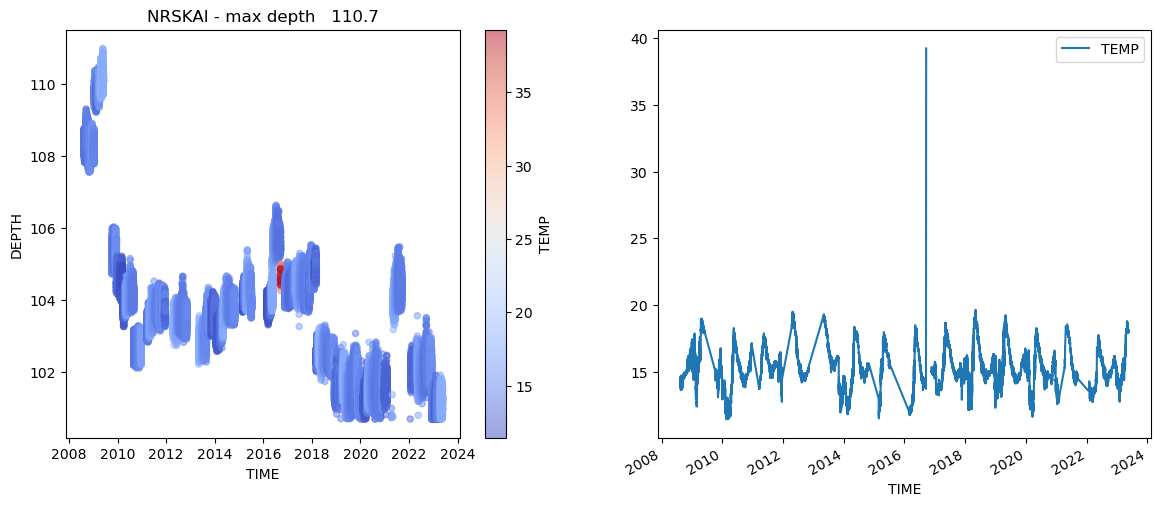

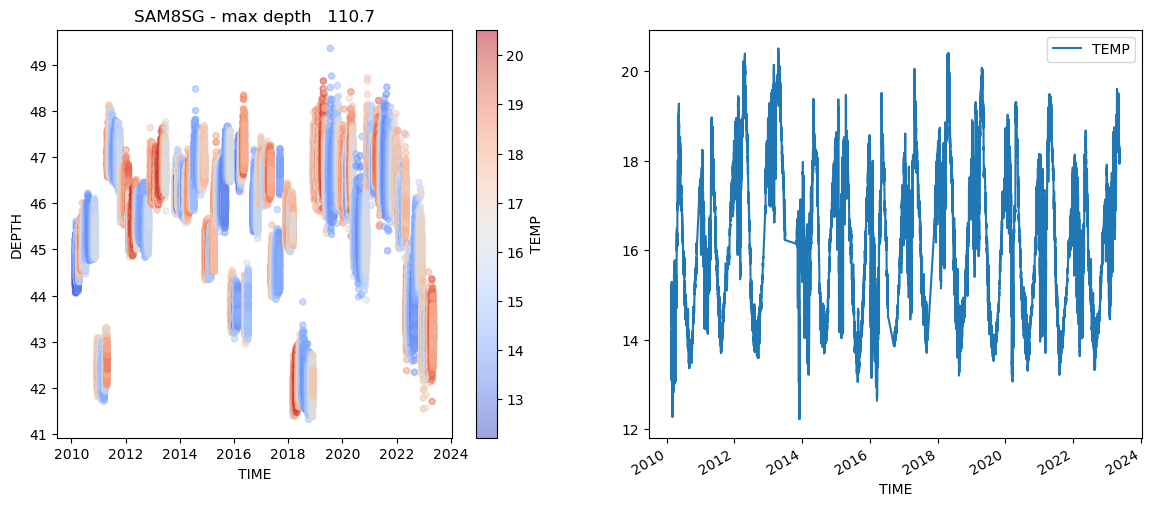

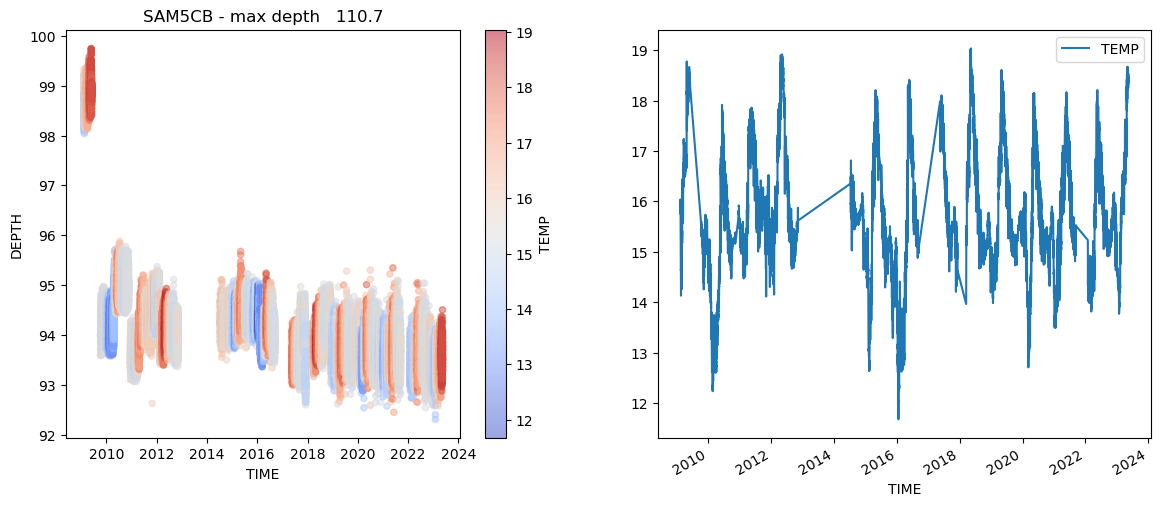

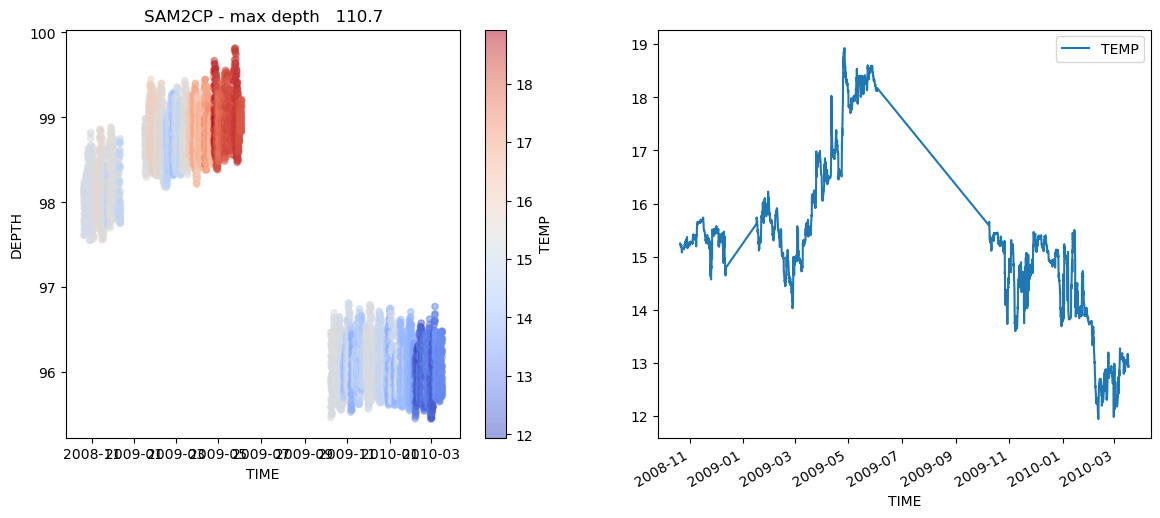

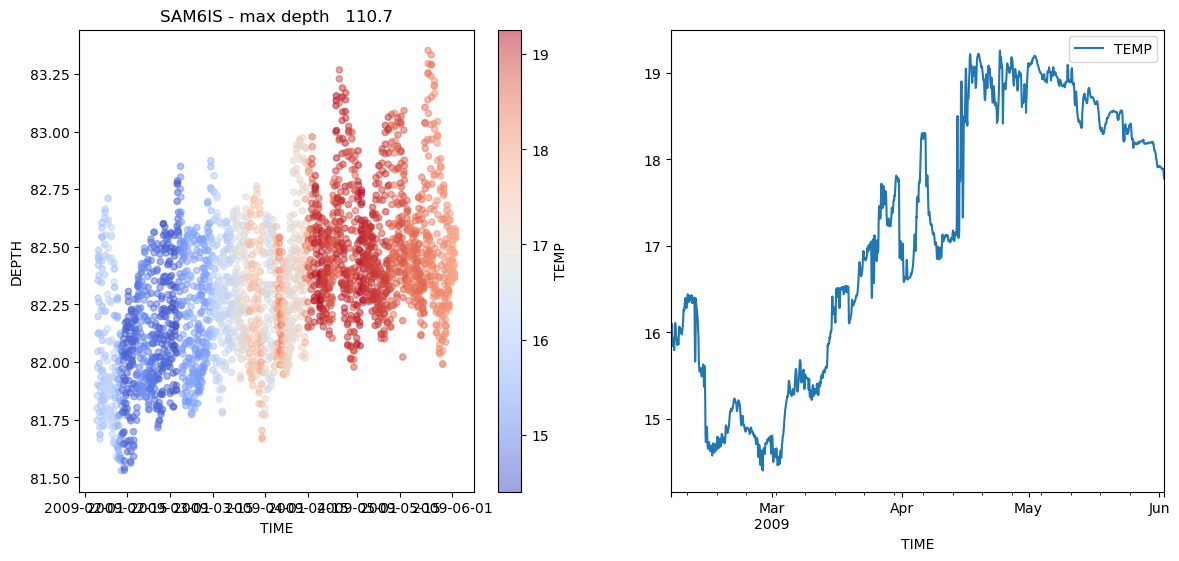

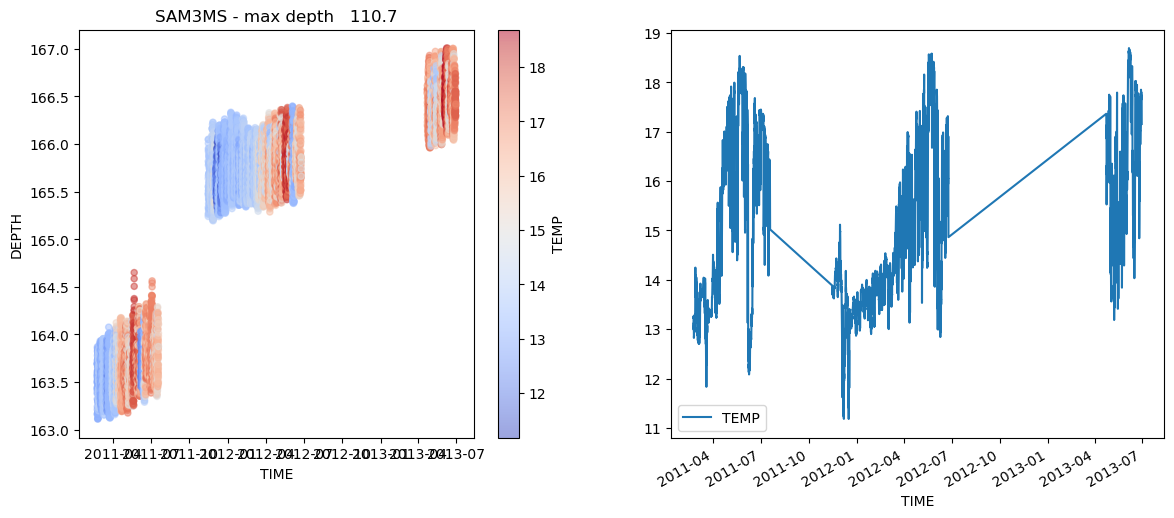

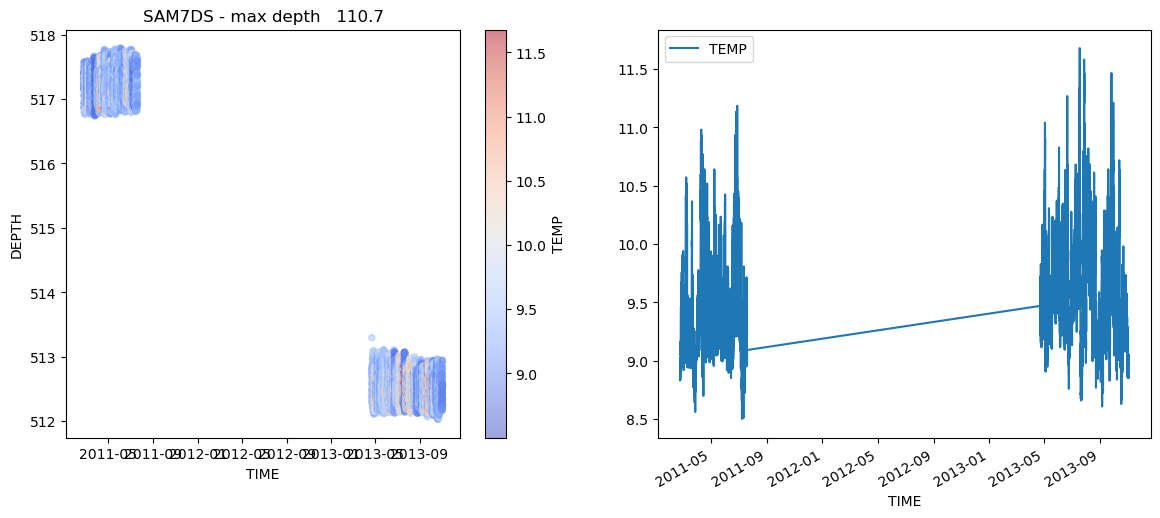

In [113]:
def plot_bottom_temp(mooring):
    """Plot the temperature values from the bottom 10m of the mooring
    """
    df = extract_timeseries_df(hourly_datasets[mooring])

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    df.plot.scatter(x="TIME", y="DEPTH", c="TEMP", cmap="coolwarm", alpha=0.5,
                   title=f"{mooring} - max depth {dmax:7.1f}", ax=axs[0])
    df.plot(x="TIME", y="TEMP", ax=axs[1])
    
for mooring in hourly_datasets.keys():
    plot_bottom_temp(mooring)